# Testing the Simulation Functions

The Hawkes module implements the multivariate Hawkes marked point process. We assume an exponential decay function is used to improve the numerical computation of the intensity function [Liniger, 2012]. Here, we test the Hawkes point process simulation to simulate the clustering of events and their associated marks.

Importing the dependencies:

In [20]:
import hawkes
import markDistributions as md
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5

Setting number of point process components and number of points to simulate:

In [21]:
d=2
numPoints=1200

Setting pre-fitted mark distribution and impact function parameters, obtained from [Liniger, 2012]:

In [22]:
eta=[0.021,0.029]
Q=[0.61,0.16,0.6,0.06]
alpha=[0.005]*d
mu=[3.6,4.2]
rho=[5.6,7.2]
alph=[0.47,1.1]
beta=[0.22,0.0]

mdParam1=[alph[0],beta[0]]
mdParam2=[alph[1],beta[1]]

param = []
param.extend(eta)
param.extend(Q)
param.extend(alpha)
param.extend(mdParam1)
param.extend(mdParam2)

markparam = [[mu[0],rho[0]],[mu[1],rho[1]]]

Instantiating a multivariate Hawkes point process object and set the parameters as above:

In [23]:
hp = hawkes.Hawkes(d=d)
hp.setParam(param)
hp.setMarkDistParam(markparam)

Also checking if model is well-defined, where the spectral radius Spr(Q) < 1:

In [24]:
print('Spr(Q)='+str(hp.ibParam.getSpectralRadius()))

Spr(Q)=0.74927647773


Simulate a Hawkes marked point process:

In [25]:
simulatedPoints, simulatedIntensities = hp.simulate(numPoints)

Checking the intervals between each simulated even points to roughly and qualitatively determine if there are clusterings (i.e. we're looking for a long interval followed by periods of short intervals):

Also, plotting the intensities over-time:

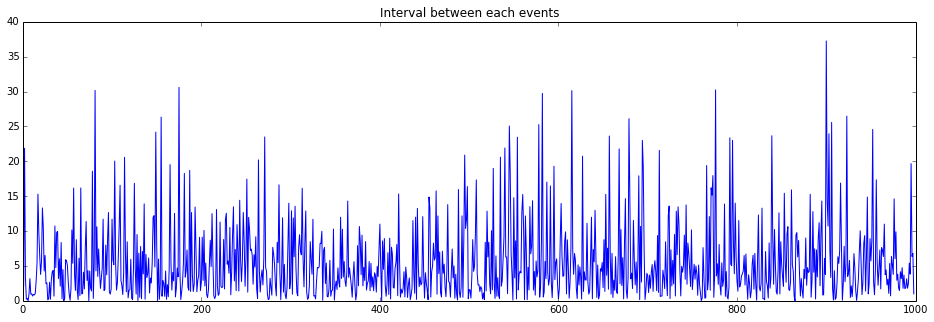

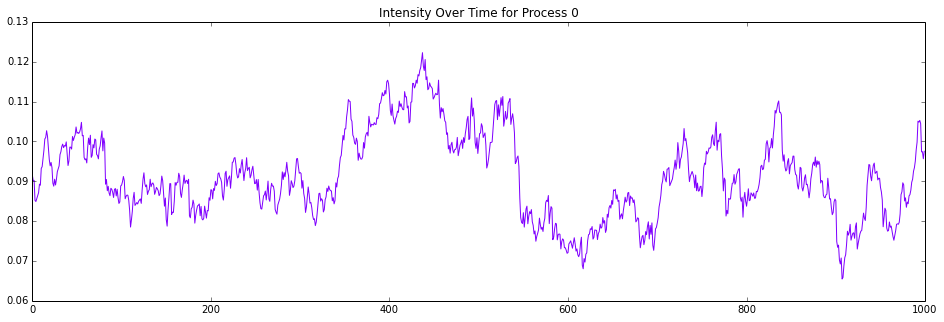

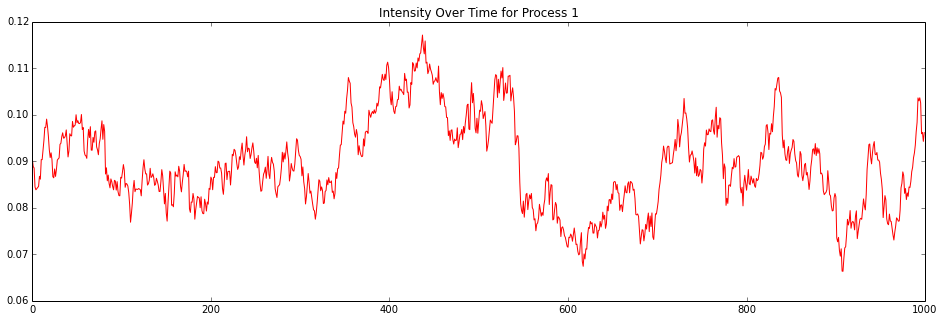

In [26]:
intervals = simulatedPoints[0][1:] - simulatedPoints[0][:-1]

plt.title('Interval between each events')
plt.plot(np.arange(len(intervals)),intervals)
plt.show()

colors = cm.rainbow(np.linspace(0, 1, d))
for i,c in zip(xrange(d), colors):
    plt.title('Intensity Over Time for Process ' + str(i))
    plt.plot(simulatedIntensities[:,i], color=c)
    plt.show()